In [1]:
from typing import Dict
from time import perf_counter_ns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cirq
import openfermion as of
import quimb.tensor as qtn
from adaptvqe.pools import FullPauliPool, TiledPauliPool
from adaptvqe.algorithms.adapt_vqe import TensorNetAdapt, LinAlgAdapt
from adaptvqe.hamiltonians import XXZHamiltonian
from adaptvqe.tensor_helpers import pauli_sum_to_mpo

## l = 4

In [2]:
max_mpo_bond = 100
system_size = 4
max_mps_bonds = [1, 4, 8]
l = system_size

dmrg_energies: Dict[int, float] = {}
for chi in max_mps_bonds:
    j_xy = 1
    j_z = 1
    h = XXZHamiltonian(j_xy, j_z, l)
    qs = cirq.LineQubit.range(l)
    h_cirq = of.transforms.qubit_operator_to_pauli_sum(h.operator)
    h_mpo = pauli_sum_to_mpo(h_cirq, qs, max_mpo_bond)

    dmrg = qtn.DMRG(h_mpo, chi)
    converged = dmrg.solve()
    if not converged:
        print("DRMG did not converge.")
    ground_energy = dmrg.energy
    print(f"At chi={chi} got energy {ground_energy}.")
    dmrg_energies[chi] = ground_energy

At chi=1 got energy (-2.170820393249942-4.440892098500626e-16j).
At chi=4 got energy (-6.46410161513777-1.0176177909031936e-15j).
At chi=8 got energy (-6.464101615137765-1.1102230246251565e-15j).


/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/cotengra/hyperoptimizers/hyper.py:55: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization. It is recommended to install one of these libraries for higher quality contraction paths.
  warnings.warn(


In [3]:
adapt_energies: Dict[int, float] = {}
adapt_runtimes: Dict[int, float] = {}

for chi in max_mps_bonds:
    j_xy = 1
    j_z = 1
    h = XXZHamiltonian(j_xy, j_z, system_size)
    start_time = perf_counter_ns()
    pool = FullPauliPool(n=system_size, max_mpo_bond=max_mpo_bond)
    tn_adapt = TensorNetAdapt(
        pool=pool,
        custom_hamiltonian=h,
        verbose=True,
        threshold=10**-5,
        max_adapt_iter=30,
        max_opt_iter=10000,
        sel_criterion="gradient",
        recycle_hessian=False,
        rand_degenerate=True,
        max_mpo_bond=max_mpo_bond,
        max_mps_bond=chi
    )
    tn_adapt.run()
    end_time = perf_counter_ns()
    elapsed_time = end_time - start_time
    print(f"For chi={chi} got energy {tn_adapt.energy} in {elapsed_time:4.5e} ns.")
    adapt_energies[chi] = tn_adapt.energy
    adapt_runtimes[chi] = elapsed_time


tensor-net-adapt prepared with the following settings:
> Pool: full_pauli_pool
> Custom Hamiltonian: XXZ_1_1
> Orbital Optimization: False
> Selection method: gradient
> Convergence criterion: total_g_norm
> Recycling Hessian: False
> Tetris: False (progressive optimization: False)
> Convergence threshold (gradient norm):  1e-05
> Maximum number of iterations:  30
> candidates per iteration:  1

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 26: -4.000000000000003
Operator 27: 4.000000000000003
Operator 30: -4.000000000000003
Operator 31: 4.000000000000003
Operator 74: 4.000000000000003
Operator 75: -4.000000000000003
Operator 78: 4.000000000000003
Operator 79: -4.000000000000003
Operator 134: 4.000000000000012
Operator 135: -4.000000000000012
Operator 146: -4.000000000000012
Operator 147: 4.000000000000012
Operator 161: -4.000000000000005
Operator 164

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -6.327276
         Iterations: 6
         Function evaluations: 27
         Gradient evaluations: 23

Current energy: -6.327276154819971
(change of -0.2041705292023286)
Current ansatz: [241, 74, 228, 45]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 1.482452149925706e-08
Operator 4: -3.956351629641475e-08
Operator 16: 1.1733849272776986e-07
Operator 21: 9.259950016493601e-08
Operator 26: 1.1048487254944339e-07
Operator 27: 0.7090385537529712
Operator 30: -6.557130740806526e-06
Operator 31: -9.560564796784465e-08
Operator 39: -0.7090337108918984
Operator 41: -1.7986255096413828e-08
Operator 45: 7.093054431400494e-08
Operator 54: -2.0894899816742836
Operator 55: -5.474564655771896e-08
Operator 57: 2.0894916250134083
Operator 61: 4.9221472675498035e-08
Operator 64: -9.259949922124644e-08
Operator 69: -1.173384933661481e-07
Operator 74: -9.560564824540041e

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -6.000000
         Iterations: 7
         Function evaluations: 57
         Gradient evaluations: 45

Current energy: -6.000000000000014
(change of -1.7639320225002155)
Current ansatz: [244, 26]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 6.742662583825165e-08
Operator 4: -6.742662583825165e-08
Operator 16: 1.4555409855177004e-07
Operator 21: 1.4555409855177004e-07
Operator 26: 1.1184078718695645e-07
Operator 27: -2.0000000000000018
Operator 30: 2.0000000000000018
Operator 31: -1.1184078718695645e-07
Operator 38: 3.371330903334524e-08
Operator 39: 2.0000000000000053
Operator 45: -2.0000000000000053
Operator 54: -2.0000000000000044
Operator 55: -3.371330759005531e-08
Operator 57: 2.0000000000000044
Operator 64: -1.4555409821870313e-07
Operator 69: -1.4555409788563622e-07
Operator 74: -1.1184078718695645e-07
Operator 75: 2.0000000000000018
Operator 78:

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -6.327276
         Iterations: 7
         Function evaluations: 31
         Gradient evaluations: 26

Current energy: -6.32727615481998
(change of -0.20417052920233303)
Current ansatz: [244, 26, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: -5.1290692137939686e-08
Operator 4: 5.1290693470207316e-08
Operator 16: -4.964116384620354e-08
Operator 21: -4.9641161847802096e-08
Operator 26: -4.487918192630502e-08
Operator 27: 0.7090385298496427
Operator 30: -6.557351997060756e-06
Operator 31: 3.501678902395611e-08
Operator 39: -0.7090336279843303
Operator 54: -2.0894899813927292
Operator 55: 2.3284778993826194e-08
Operator 57: 2.0894916447538883
Operator 64: 4.9641162735980515e-08
Operator 69: 4.9641164068248145e-08
Operator 74: 3.50167888019115e-08
Operator 75: -6.5573519970468785e-06
Operator 78: 0.7090385298496427
Operator 79: -4.487918170426042e-

In [4]:
records = []
for chi in max_mps_bonds:
    records.append((chi, dmrg_energies[chi], adapt_energies[chi], adapt_runtimes[chi]))
df = pd.DataFrame.from_records(records, columns=["chi", "dmrg_energy", "adapt_energy", "adapt_runtime"])
df.to_csv("../data/xxz_energy_vs_bond.csv")

In [5]:
df["error"] = np.abs(df['dmrg_energy'] - df["adapt_energy"])

In [6]:
print(df.head())

   chi         dmrg_energy  adapt_energy  adapt_runtime         error
0    1 -2.170820-0.000000j     -3.000000     7822259542  8.291796e-01
1    4 -6.464102-0.000000j     -6.464102     8859388458  7.320278e-11
2    8 -6.464102-0.000000j     -6.464102    10060812500  7.917222e-11


/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, '$\\chi$')

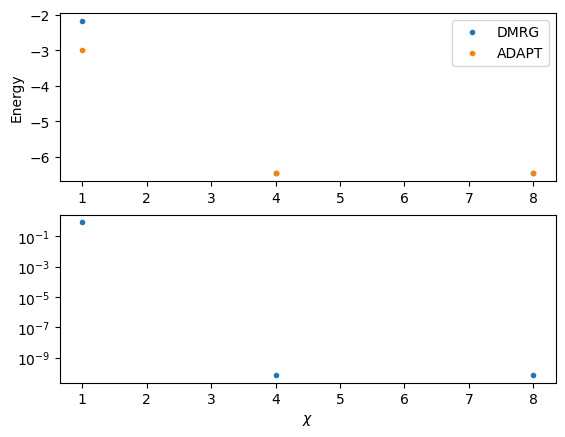

In [7]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(df["chi"], df["dmrg_energy"], '.', label="DMRG")
ax[0].plot(df["chi"], df["adapt_energy"], '.', label="ADAPT")
ax[0].legend()
ax[0].set_ylabel("Energy")
ax[1].plot(df["chi"], df["error"], '.')
ax[1].set_yscale("log")
ax[1].set_xlabel(r"$\chi$")

## l = 6

In [8]:
max_mpo_bond = 100
system_size = 6
max_mps_bonds = [1, 4, 8]
l = system_size

dmrg_energies: Dict[int, float] = {}
for chi in max_mps_bonds:
    j_xy = 1
    j_z = 1
    h = XXZHamiltonian(j_xy, j_z, l)
    qs = cirq.LineQubit.range(l)
    h_cirq = of.transforms.qubit_operator_to_pauli_sum(h.operator)
    h_mpo = pauli_sum_to_mpo(h_cirq, qs, max_mpo_bond)

    dmrg = qtn.DMRG(h_mpo, chi)
    converged = dmrg.solve()
    if not converged:
        print("DRMG did not converge.")
    ground_energy = dmrg.energy
    print(f"At chi={chi} got energy {ground_energy}.")
    dmrg_energies[chi] = ground_energy

At chi=1 got energy (-3.618033779385804+2.3314683517128287e-15j).
At chi=4 got energy (-9.970167158143234+1.6653345369377348e-15j).
At chi=8 got energy (-9.97430853555169+7.771561172376096e-16j).


In [9]:
adapt_energies: Dict[int, float] = {}
adapt_runtimes: Dict[int, float] = {}

for chi in max_mps_bonds:
    j_xy = 1
    j_z = 1
    h = XXZHamiltonian(j_xy, j_z, system_size)
    start_time = perf_counter_ns()
    pool = FullPauliPool(n=system_size, max_mpo_bond=max_mpo_bond)
    tn_adapt = TensorNetAdapt(
        pool=pool,
        custom_hamiltonian=h,
        verbose=True,
        threshold=10**-5,
        max_adapt_iter=30,
        max_opt_iter=10000,
        sel_criterion="gradient",
        recycle_hessian=False,
        rand_degenerate=True,
        max_mpo_bond=max_mpo_bond,
        max_mps_bond=chi
    )
    tn_adapt.run()
    end_time = perf_counter_ns()
    elapsed_time = end_time - start_time
    print(f"For chi={chi} got energy {tn_adapt.energy} in {elapsed_time:4.5e} ns.")
    adapt_energies[chi] = tn_adapt.energy
    adapt_runtimes[chi] = elapsed_time


tensor-net-adapt prepared with the following settings:
> Pool: full_pauli_pool
> Custom Hamiltonian: XXZ_1_1
> Orbital Optimization: False
> Selection method: gradient
> Convergence criterion: total_g_norm
> Recycling Hessian: False
> Tetris: False (progressive optimization: False)
> Convergence threshold (gradient norm):  1e-05
> Maximum number of iterations:  30
> candidates per iteration:  1

Initial energy: -4.999999999999999

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 426: 3.9999999999999964
Operator 427: -3.9999999999999964
Operator 430: 3.9999999999999964
Operator 431: -3.9999999999999964
Operator 442: -3.9999999999999964
Operator 443: 3.9999999999999964
Operator 446: -3.9999999999999964
Operator 447: 3.9999999999999964
Operator 490: 3.9999999999999964
Operator 491: -3.9999999999999964
Operator 494: 3.9999999999999964
Operator 495: -3.9999999999999964
Operator 506: -3.999999999

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.000000
         Iterations: 10
         Function evaluations: 92
         Gradient evaluations: 79

Current energy: -9.000000000000028
(change of -1.7049644418179222)
Current ansatz: [4081, 3919, 1279]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: -3.9703694554305e-08
Operator 4: 3.9703694554305e-08
Operator 16: -3.6718018514569906e-08
Operator 21: -3.671801918070372e-08
Operator 26: -1.6866170904350497e-08
Operator 27: 2.0000000000000053
Operator 30: -2.0000000000000053
Operator 31: 1.6866170904350497e-08
Operator 38: -1.985184905350934e-08
Operator 39: -2.0000000000000067
Operator 45: 2.0000000000000067
Operator 54: 2.000000000000006
Operator 55: 1.98518472771525e-08
Operator 57: -2.0000000000000058
Operator 64: 3.6718018514569906e-08
Operator 69: 3.671801918070372e-08
Operator 74: 1.686617057128359e-08
Operator 75: -2.0000000000000058
Operator 78

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.123106
         Iterations: 5
         Function evaluations: 61
         Gradient evaluations: 49

Current energy: -9.123105625617644
(change of -0.12310562561761529)
Current ansatz: [4081, 3919, 1279, 4065]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: -5.7442438500254767e-08
Operator 4: 5.744243847249919e-08
Operator 16: -8.554370691665758e-08
Operator 21: -8.554370744401352e-08
Operator 26: -7.381581707682772e-08
Operator 27: 8.576192490516264e-07
Operator 30: -8.576192492537841e-07
Operator 31: 7.381581707682772e-08
Operator 38: -2.872122180364034e-08
Operator 39: -1.940285050738846
Operator 45: 2.485071048279899
Operator 54: 1.9402850507388445
Operator 55: 2.8721220204225295e-08
Operator 57: -2.4850710482798988
Operator 64: 8.554370607705142e-08
Operator 69: 8.554370613950146e-08
Operator 74: 7.381581655988012e-08
Operator 75: -8.57619248990196

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Operator 198: 0.02565007399259165
Operator 199: 2.1546551088912458e-07
Operator 201: -0.7360299795631569
Operator 205: 3.68376126562271e-07
Operator 210: 2.0830414319610338
Operator 211: -9.554157103559552e-07
Operator 216: -2.089553239106312
Operator 220: -9.51172297146327e-08
Operator 225: 0.7168759118391839
Operator 228: 1.580087678085841e-05
Operator 241: -1.8520464462368134e-06
Operator 244: 1.8316300601426443e-06
Operator 256: -3.1051359439260295e-07
Operator 261: -2.9370861298616546e-07
Operator 266: -2.780467793783714e-07
Operator 271: 2.9395564560275034e-07
Operator 273: 9.462947425653567e-08
Operator 276: -1.0004384187745075e-07
Operator 296: -3.246587354510666e-08
Operator 307: -9.539344536513283e-08
Operator 316: 1.0076677248171961e-07
Operator 321: -1.0004384254358456e-07
Operator 324: 9.462947425653567e-08
Operator 336: -2.937086138743439e-07
Operator 341: -3.105135952807814e-07
Operator 346: -2.9395564649092876e-07
Operator 351: 2.7804678204290667e-07
Operator 358: 9.539

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.464057
         Iterations: 5
         Function evaluations: 57
         Gradient evaluations: 45

Current energy: -9.464056642858353
(change of -0.1368020364444824)
Current ansatz: [4081, 3919, 1279, 4065, 3987, 3954]

*** ADAPT-VQE Iteration 7 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 4.521319917443942e-06
Operator 4: -4.55019096558116e-06
Operator 16: 2.537371921308793e-07
Operator 21: 2.2486614421153225e-07
Operator 26: -1.1599676935753703e-06
Operator 27: -0.009667862121960717
Operator 30: 0.014486036051015028
Operator 31: 1.2042213907545625e-06
Operator 38: 7.250172339849409e-07
Operator 39: 0.01199815895038967
Operator 41: 6.583568537709859e-07
Operator 45: -0.01767186354428348
Operator 54: -0.02994008857563817
Operator 55: -8.933641390897239e-07
Operator 57: 0.030795619240559496
Operator 61: -5.260426346410853e-07
Operator 64: -2.2486614321905359e-07
Operator 69: 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.592537
         Iterations: 8
         Function evaluations: 54
         Gradient evaluations: 42

Current energy: -9.592536550889625
(change of -0.12847990803127196)
Current ansatz: [4081, 3919, 1279, 4065, 3987, 3954, 3648]

*** ADAPT-VQE Iteration 8 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: -0.00026148995337184344
Operator 4: 0.00023713738421264619
Operator 16: 0.00021664753320427277
Operator 21: 0.0001922949640458249
Operator 26: 0.0003184884658012366
Operator 27: 0.08469850602321555
Operator 30: -0.07980862486827572
Operator 31: -0.0002762427288943159
Operator 38: -0.0001305012862308358
Operator 39: -0.04639871703986662
Operator 41: 5.8857327661365755e-06
Operator 45: 0.027479705034352674
Operator 54: 0.028192091811965678
Operator 55: -2.668787703903608e-05
Operator 57: -0.014195341128795372
Operator 61: 0.0001083604021357154
Operator 64: -0.00019229496404454816
Oper

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.811836
         Iterations: 7
         Function evaluations: 62
         Gradient evaluations: 50

Current energy: -9.811836498784691
(change of -0.2192999478950668)
Current ansatz: [4081, 3919, 1279, 4065, 3987, 3954, 3648, 2367]

*** ADAPT-VQE Iteration 9 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: -0.0022192990382231374
Operator 4: 0.002131011569193335
Operator 16: 0.0007767582622227121
Operator 21: 0.0006906285389403927
Operator 26: 0.0014935541160298474
Operator 27: 0.0007249409975401335
Operator 30: -0.007631865698265715
Operator 31: -0.0013413046835991397
Operator 38: -0.0006739086525158337
Operator 39: 0.014429606606140254
Operator 41: -0.000148084155163989
Operator 45: -0.01337059034656307
Operator 54: 0.010370883509540874
Operator 55: 0.00011428042555834033
Operator 57: -0.004515464553179533
Operator 61: 0.0005741200335613351
Operator 64: -0.0006884707931914379
Op

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Operator 3305: 0.0006367075465718575
Operator 3309: 0.10319999981672151
Operator 3318: 0.2834819003233977
Operator 3319: -0.0002778263207844911
Operator 3321: -0.28499705372473416
Operator 3325: -0.00015758809252486294
Operator 3330: 0.38700095677123936
Operator 3331: -0.00012480253948804476
Operator 3336: -0.2776933599247519
Operator 3340: 7.584157592679941e-05
Operator 3350: 0.2583901932539685
Operator 3351: -9.261024880460877e-05
Operator 3353: -0.09762713201402395
Operator 3357: 7.264523680233781e-05
Operator 3360: -0.09745560972904176
Operator 3365: -0.148710212632618
Operator 3370: 0.011603279162424238
Operator 3371: 5.619799106566792e-05
Operator 3374: -0.00010300083734851584
Operator 3375: 0.16670441984741596
Operator 3376: -0.00021361791440605016
Operator 3381: -0.00016451399434551373
Operator 3386: -0.0001709043781182827
Operator 3387: 0.031905491141426136
Operator 3390: -0.20986669903385213
Operator 3391: 0.00018090273376877852
Operator 3398: -0.25868303241814605
Operator 33

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.958979
         Iterations: 2
         Function evaluations: 66
         Gradient evaluations: 54

Current energy: -9.958978502930268
(change of -0.0044050567652114125)
Current ansatz: [4081, 3919, 1279, 4065, 3987, 3954, 3648, 2367, 1834, 1278]

*** ADAPT-VQE Iteration 11 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 0.0005828961635998553
Operator 4: -0.0007606839328562209
Operator 16: 0.0014633249327693498
Operator 21: 0.0012876371479073612
Operator 26: 0.0013955743658786712
Operator 27: 0.008975582411239984
Operator 30: -0.01125429251141678
Operator 31: -0.0010805317060847974
Operator 38: -0.00048191226699295653
Operator 39: 0.0069759972331914335
Operator 41: 0.00038306849668057197
Operator 45: -0.006111931255032229
Operator 54: 0.0011164781907608279
Operator 55: -0.0006543505401996885
Operator 57: -0.001439680333842094
Operator 61: 0.00044293995141231335
Operator 64: -0.0

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.958979
         Iterations: 0
         Function evaluations: 42
         Gradient evaluations: 31

Current energy: -9.958978502930265
(change of 3.552713678800501e-15)
Current ansatz: [4081, 3919, 1279, 4065, 3987, 3954, 3648, 2367, 1834, 1278, 2307]

*** ADAPT-VQE Iteration 12 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 0.0005828961635989671
Operator 4: -0.0007606839328575532
Operator 16: 0.0014633249327684617
Operator 21: 0.0012876371479095816
Operator 26: 0.0013955743658795594
Operator 27: 0.00897558241123874
Operator 30: -0.011254292511415291
Operator 31: -0.0010805317060851305
Operator 38: -0.0004819122669947884
Operator 39: 0.0069759972331907595
Operator 41: 0.0003830684966836806
Operator 45: -0.006111931255030189
Operator 54: 0.001116478190761945
Operator 55: -0.0006543505401986893
Operator 57: -0.0014396803338452661
Operator 61: 0.0004429399514100929
Operator 64: -0

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.959257
         Iterations: 2
         Function evaluations: 62
         Gradient evaluations: 50

Current energy: -9.959257100420825
(change of -0.00027859749055991756)
Current ansatz: [4081, 3919, 1279, 4065, 3987, 3954, 3648, 2367, 1834, 1278, 2307, 2307]

*** ADAPT-VQE Iteration 13 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 0.000543663133256933
Operator 4: -0.000694270138464681
Operator 16: 0.0012332367352566598
Operator 21: 0.001084140912775866
Operator 26: 0.0011589231156546864
Operator 27: 0.0157948892571442
Operator 30: -0.019254517803129888
Operator 31: -0.000892301836686038
Operator 38: -0.00039908264584917474
Operator 39: 0.009622479777772187
Operator 41: 0.0003314809968685273
Operator 45: -0.007846754783681666
Operator 54: 0.0007654090376557822
Operator 55: -0.0005646615482128858
Operator 57: 2.9306580087185515e-05
Operator 61: 0.00037054029160221713
Operator 6

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Operator 844: 0.00012313938038973314
Operator 854: 0.37747409413878613
Operator 855: -0.00010057606845421257
Operator 857: -0.2789273356951844
Operator 861: -8.157885128548537e-06
Operator 864: -0.21247758041383913
Operator 869: -0.14002967978443237
Operator 874: -0.033801828618146915
Operator 875: -6.0061417162415864e-05
Operator 878: 4.0929958731377586e-05
Operator 879: 0.19179220498416727
Operator 880: -0.0002147089870213649
Operator 885: -0.00015326516312952343
Operator 890: -0.00021379951492404674
Operator 891: 0.10544544878380455
Operator 894: -0.2641019491764426
Operator 895: 0.00024940896639931084
Operator 897: -0.2910002445166151
Operator 900: 0.10864072073704197
Operator 912: 0.21329048932494402
Operator 917: 0.030517148428258752
Operator 922: 0.17576149763732746
Operator 923: -0.00020547456228672822
Operator 926: 0.00019755424120961734
Operator 927: -0.22276621848348488
Operator 934: 0.24586993554031755
Operator 935: 1.4162846163404824e-05
Operator 937: -0.3989829217795648
O

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.959257
         Iterations: 0
         Function evaluations: 36
         Gradient evaluations: 25

Current energy: -9.95925710042083
(change of 5.329070518200751e-15)
Current ansatz: [4081, 3919, 1279, 4065, 3987, 3954, 3648, 2367, 1834, 1278, 2307, 2307, 3330, 3330]

*** ADAPT-VQE Iteration 15 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 0.0005436631332549346
Operator 4: -0.000694270138459574
Operator 16: 0.001233236735252552
Operator 21: 0.0010841409127746449
Operator 26: 0.0011589231156543811
Operator 27: 0.01579488925714587
Operator 30: -0.019254517803130533
Operator 31: -0.0008923018366856772
Operator 38: -0.0003990826458508401
Operator 39: 0.009622479777770327
Operator 41: 0.0003314809968701926
Operator 45: -0.007846754783679957
Operator 54: 0.0007654090376571517
Operator 55: -0.0005646615482106654
Operator 57: 2.930658008560037e-05
Operator 61: 0.0003705402915994416
O

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.959269
         Iterations: 1
         Function evaluations: 46
         Gradient evaluations: 34

Current energy: -9.959268969937227
(change of -1.1869516397311486e-05)
Current ansatz: [4081, 3919, 1279, 4065, 3987, 3954, 3648, 2367, 1834, 1278, 2307, 2307, 3330, 3330, 3330]

*** ADAPT-VQE Iteration 16 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 0.000533261778008054
Operator 4: -0.0006804487631422163
Operator 16: 0.00120440573499625
Operator 21: 0.001058982557205379
Operator 26: 0.0011305222019457606
Operator 27: 0.01815108763629367
Operator 30: -0.021550242447397464
Operator 31: -0.000870159151548977
Operator 38: -0.00038929571877632796
Operator 39: 0.008309361083612798
Operator 41: 0.0003254978835074418
Operator 45: -0.006061718510001996
Operator 54: 0.000984628092275664
Operator 55: -0.0005543463778538982
Operator 57: -0.0006884457306800828
Operator 61: 0.00036351757333

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.959287
         Iterations: 1
         Function evaluations: 47
         Gradient evaluations: 36

Current energy: -9.959286832088157
(change of -1.7862150929914833e-05)
Current ansatz: [4081, 3919, 1279, 4065, 3987, 3954, 3648, 2367, 1834, 1278, 2307, 2307, 3330, 3330, 3330, 2055]

*** ADAPT-VQE Iteration 17 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 0.0005227777435879571
Operator 4: -0.0006663150884494012
Operator 16: 0.0011741643254122927
Operator 21: 0.0010328985560803597
Operator 26: 0.001100982710018121
Operator 27: 0.02074115951063637
Operator 30: -0.026291924120050016
Operator 31: -0.0008472450794625684
Operator 38: -0.00037906637659604163
Operator 39: 0.01331079971067199
Operator 41: 0.00031949506956082535
Operator 45: -0.011578137676111952
Operator 54: 0.0019662468354733798
Operator 55: -0.000544830208259791
Operator 57: 0.0013561463775177925
Operator 61: 0.00035

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.960293
         Iterations: 3
         Function evaluations: 66
         Gradient evaluations: 55

Current energy: -9.960293144935045
(change of -0.00077372653656127)
Current ansatz: [4081, 3919, 1279, 4065, 3987, 3954, 3648, 2367, 1834, 1278, 2307, 2307, 3330, 3330, 3330, 2055, 2055, 3078]

*** ADAPT-VQE Iteration 19 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 0.000396571922114175
Operator 4: -0.0004613205819112842
Operator 16: 0.0005162901934118724
Operator 21: 0.0004614362610176337
Operator 26: 0.0004398003875501766
Operator 27: 0.01765175800227827
Operator 30: -0.03645856389618216
Operator 31: -0.00033614229404121954
Operator 38: -0.0001334095993307527
Operator 39: 0.04774760460133196
Operator 41: 0.0001512038497218371
Operator 45: -0.05563427675414119
Operator 54: -0.009512673320207695
Operator 55: -0.0003122028284060774
Operator 57: 0.03687840297108417
Operator 61: 0.

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.960293
         Iterations: 0
         Function evaluations: 39
         Gradient evaluations: 28

Current energy: -9.960293144935058
(change of -1.2434497875801753e-14)
Current ansatz: [4081, 3919, 1279, 4065, 3987, 3954, 3648, 2367, 1834, 1278, 2307, 2307, 3330, 3330, 3330, 2055, 2055, 3078, 2396]

*** ADAPT-VQE Iteration 20 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 0.0003965719221130648
Operator 4: -0.0004613205819117283
Operator 16: 0.0005162901934099295
Operator 21: 0.00046143626101669
Operator 26: 0.0004398003875509815
Operator 27: 0.017651758002279933
Operator 30: -0.03645856389618303
Operator 31: -0.0003361422940415526
Operator 38: -0.00013340959933039187
Operator 39: 0.04774760460133187
Operator 41: 0.00015120384972178158
Operator 45: -0.055634276754141766
Operator 54: -0.009512673320208404
Operator 55: -0.0003122028284069378
Operator 57: 0.03687840297108523
Oper

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.960293
         Iterations: 0
         Function evaluations: 35
         Gradient evaluations: 24

Current energy: -9.960293144935044
(change of 1.4210854715202004e-14)
Current ansatz: [4081, 3919, 1279, 4065, 3987, 3954, 3648, 2367, 1834, 1278, 2307, 2307, 3330, 3330, 3330, 2055, 2055, 3078, 2396, 3081]

*** ADAPT-VQE Iteration 21 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 0.0003965719221161734
Operator 4: -0.000461320581915281
Operator 16: 0.0005162901934094855
Operator 21: 0.00046143626101491364
Operator 26: 0.00043980038754964923
Operator 27: 0.017651758002280235
Operator 30: -0.036458563896185
Operator 31: -0.00033614229403933216
Operator 38: -0.00013340959932983676
Operator 39: 0.04774760460133204
Operator 41: 0.0001512038497213375
Operator 45: -0.0556342767541421
Operator 54: -0.009512673320206125
Operator 55: -0.000312202828407937
Operator 57: 0.036878402971084114


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.960293
         Iterations: 0
         Function evaluations: 38
         Gradient evaluations: 28

Current energy: -9.96029314493504
(change of 3.552713678800501e-15)
Current ansatz: [4081, 3919, 1279, 4065, 3987, 3954, 3648, 2367, 1834, 1278, 2307, 2307, 3330, 3330, 3330, 2055, 2055, 3078, 2396, 3081, 2396]

*** ADAPT-VQE Iteration 22 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 0.0003965719221161734
Operator 4: -0.00046132058191084013
Operator 16: 0.0005162901934052666
Operator 21: 0.00046143626101002866
Operator 26: 0.00043980038754531936
Operator 27: 0.017651758002281623
Operator 30: -0.036458563896186326
Operator 31: -0.0003361422940361125
Operator 38: -0.00013340959932972574
Operator 39: 0.047747604601332025
Operator 41: 0.00015120384972000522
Operator 45: -0.055634276754141995
Operator 54: -0.00951267332020453
Operator 55: -0.0003122028284081868
Operator 57: 0.0368784

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.960293
         Iterations: 0
         Function evaluations: 40
         Gradient evaluations: 29

Current energy: -9.960293144935035
(change of 5.329070518200751e-15)
Current ansatz: [4081, 3919, 1279, 4065, 3987, 3954, 3648, 2367, 1834, 1278, 2307, 2307, 3330, 3330, 3330, 2055, 2055, 3078, 2396, 3081, 2396, 3081]

*** ADAPT-VQE Iteration 23 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 0.0003965719221146191
Operator 4: -0.00046132058191239445
Operator 16: 0.0005162901934034347
Operator 21: 0.00046143626100902946
Operator 26: 0.00043980038754226625
Operator 27: 0.017651758002281494
Operator 30: -0.036458563896185354
Operator 31: -0.00033614229403285123
Operator 38: -0.00013340959933078045
Operator 39: 0.047747604601330956
Operator 41: 0.00015120384972217016
Operator 45: -0.055634276754141614
Operator 54: -0.00951267332020436
Operator 55: -0.00031220282841153135
Operator 57: 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.960293
         Iterations: 0
         Function evaluations: 44
         Gradient evaluations: 33

Current energy: -9.960293144935045
(change of -1.0658141036401503e-14)
Current ansatz: [4081, 3919, 1279, 4065, 3987, 3954, 3648, 2367, 1834, 1278, 2307, 2307, 3330, 3330, 3330, 2055, 2055, 3078, 2396, 3081, 2396, 3081, 1014]

*** ADAPT-VQE Iteration 24 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 0.0003965719221135089
Operator 4: -0.0004613205819087862
Operator 16: 0.0005162901933989106
Operator 21: 0.00046143626100628166
Operator 26: 0.00043980038753982376
Operator 27: 0.01765175800228157
Operator 30: -0.03645856389618549
Operator 31: -0.00033614229402972873
Operator 38: -0.00013340959933260538
Operator 39: 0.047747604601329485
Operator 41: 0.00015120384972280854
Operator 45: -0.05563427675413954
Operator 54: -0.00951267332020446
Operator 55: -0.0003122028284102685
Operator 5

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.960293
         Iterations: 0
         Function evaluations: 41
         Gradient evaluations: 30

Current energy: -9.960293144935047
(change of -1.7763568394002505e-15)
Current ansatz: [4081, 3919, 1279, 4065, 3987, 3954, 3648, 2367, 1834, 1278, 2307, 2307, 3330, 3330, 3330, 2055, 2055, 3078, 2396, 3081, 2396, 3081, 1014, 2396]

*** ADAPT-VQE Iteration 25 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 0.0003965719221170616
Operator 4: -0.00046132058191439285
Operator 16: 0.0005162901933992714
Operator 21: 0.0004614362610051437
Operator 26: 0.000439800387538547
Operator 27: 0.017651758002282802
Operator 30: -0.03645856389618751
Operator 31: -0.0003361422940311165
Operator 38: -0.00013340959932728325
Operator 39: 0.047747604601329874
Operator 41: 0.0001512038497204493
Operator 45: -0.05563427675413962
Operator 54: -0.009512673320202447
Operator 55: -0.000312202828407826
Operato

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.960573
         Iterations: 1
         Function evaluations: 62
         Gradient evaluations: 50

Current energy: -9.960573480540962
(change of -0.0002803356059146722)
Current ansatz: [4081, 3919, 1279, 4065, 3987, 3954, 3648, 2367, 1834, 1278, 2307, 2307, 3330, 3330, 3330, 2055, 2055, 3078, 2396, 3081, 2396, 3081, 1014, 2396, 1699]

*** ADAPT-VQE Iteration 26 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 0.0003514090822198668
Operator 4: -0.00041558069494262995
Operator 16: 0.0004669482610142883
Operator 21: 0.00040251183773576393
Operator 26: 0.00036924117012307467
Operator 27: 0.03867788577006972
Operator 30: 0.026945350401646907
Operator 31: -0.0002758795576445483
Operator 38: -0.000106467406021854
Operator 39: -0.028455227367677943
Operator 41: 0.00014012966738791155
Operator 45: -0.04088018492200607
Operator 54: -0.18554918727260908
Operator 55: -0.0002312979261730186


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.960573
         Iterations: 0
         Function evaluations: 85
         Gradient evaluations: 73

Current energy: -9.960573480540972
(change of -1.0658141036401503e-14)
Current ansatz: [4081, 3919, 1279, 4065, 3987, 3954, 3648, 2367, 1834, 1278, 2307, 2307, 3330, 3330, 3330, 2055, 2055, 3078, 2396, 3081, 2396, 3081, 1014, 2396, 1699, 3555]

*** ADAPT-VQE Iteration 27 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 0.0003514090822189786
Operator 4: -0.0004155806949412977
Operator 16: 0.0004669482610131226
Operator 21: 0.00040251183773687416
Operator 26: 0.0003692411701230469
Operator 27: 0.03867788577007004
Operator 30: 0.026945350401645966
Operator 31: -0.00027587955764563077
Operator 38: -0.00010646740602382465
Operator 39: -0.028455227367678197
Operator 41: 0.0001401296673906316
Operator 45: -0.04088018492200533
Operator 54: -0.18554918727260789
Operator 55: -0.0002312979261

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.960573
         Iterations: 0
         Function evaluations: 88
         Gradient evaluations: 76

Current energy: -9.96057348054098
(change of -7.105427357601002e-15)
Current ansatz: [4081, 3919, 1279, 4065, 3987, 3954, 3648, 2367, 1834, 1278, 2307, 2307, 3330, 3330, 3330, 2055, 2055, 3078, 2396, 3081, 2396, 3081, 1014, 2396, 1699, 3555, 540]

*** ADAPT-VQE Iteration 28 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 0.0003514090822174243
Operator 4: -0.0004155806949398544
Operator 16: 0.0004669482610147324
Operator 21: 0.0004025118377395387
Operator 26: 0.00036924117012551716
Operator 27: 0.038677885770068206
Operator 30: 0.02694535040164743
Operator 31: -0.0002758795576470463
Operator 38: -0.0001064674060211046
Operator 39: -0.02845522736767699
Operator 41: 0.00014012966738830013
Operator 45: -0.040880184922006305
Operator 54: -0.1855491872726072
Operator 55: -0.000231297926

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.960573
         Iterations: 0
         Function evaluations: 82
         Gradient evaluations: 70

Current energy: -9.960573480540958
(change of 2.1316282072803006e-14)
Current ansatz: [4081, 3919, 1279, 4065, 3987, 3954, 3648, 2367, 1834, 1278, 2307, 2307, 3330, 3330, 3330, 2055, 2055, 3078, 2396, 3081, 2396, 3081, 1014, 2396, 1699, 3555, 540, 2230]

*** ADAPT-VQE Iteration 29 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 0.0003514090822218652
Operator 4: -0.0004155806949435181
Operator 16: 0.00046694826100890374
Operator 21: 0.00040251183773443167
Operator 26: 0.0003692411701191056
Operator 27: 0.038677885770067845
Operator 30: 0.026945350401647774
Operator 31: -0.0002758795576407458
Operator 38: -0.00010646740601866211
Operator 39: -0.028455227367674536
Operator 41: 0.00014012966738652377
Operator 45: -0.04088018492200805
Operator 54: -0.18554918727260664
Operator 55: -0.0

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.960573
         Iterations: 0
         Function evaluations: 84
         Gradient evaluations: 72

Current energy: -9.960573480540972
(change of -1.4210854715202004e-14)
Current ansatz: [4081, 3919, 1279, 4065, 3987, 3954, 3648, 2367, 1834, 1278, 2307, 2307, 3330, 3330, 3330, 2055, 2055, 3078, 2396, 3081, 2396, 3081, 1014, 2396, 1699, 3555, 540, 2230, 3555]

*** ADAPT-VQE Iteration 30 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 0.0003514090822210325
Operator 4: -0.00041558069494207484
Operator 16: 0.00046694826100877884
Operator 21: 0.00040251183773437615
Operator 26: 0.00036924117012041013
Operator 27: 0.03867788577006991
Operator 30: 0.026945350401645328
Operator 31: -0.00027587955764132865
Operator 38: -0.00010646740602007418
Operator 39: -0.028455227367676854
Operator 41: 0.0001401296673866348
Operator 45: -0.040880184922005944
Operator 54: -0.18554918727260594
Operator

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.960573
         Iterations: 0
         Function evaluations: 94
         Gradient evaluations: 82

Current energy: -9.960573480540958
(change of 1.4210854715202004e-14)
Current ansatz: [4081, 3919, 1279, 4065, 3987, 3954, 3648, 2367, 1834, 1278, 2307, 2307, 3330, 3330, 3330, 2055, 2055, 3078, 2396, 3081, 2396, 3081, 1014, 2396, 1699, 3555, 540, 2230, 3555, 3555]
Performing final convergence check...
Total gradient norm: 2.862400532381293

The maximum number of iterations (30) was hit before the convergence criterion was satisfied.
(current gradient norm is 2.8624005323812938 > 1e-05)
For chi=4 got energy -9.960573480540958 in 3.52307e+11 ns.

tensor-net-adapt prepared with the following settings:
> Pool: full_pauli_pool
> Custom Hamiltonian: XXZ_1_1
> Orbital Optimization: False
> Selection method: gradient
> Convergence criterion: total_g_norm
> Recycling Hessian: False
> Tetris: False (progressive optimization: False)
> Convergence threshold (gradi

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.327276
         Iterations: 5
         Function evaluations: 54
         Gradient evaluations: 49

Current energy: -9.327276154819979
(change of -0.20417052920232592)
Current ansatz: [4084, 3866, 1274, 4056, 4020]

*** ADAPT-VQE Iteration 6 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: -3.083266142400731e-08
Operator 4: 3.565155226592509e-08
Operator 16: -1.7352342118748254e-08
Operator 21: -1.2533450943763569e-08
Operator 27: -0.7090336317080387
Operator 38: -2.1033553351777258e-08
Operator 39: 0.7090385309225347
Operator 41: 1.4726556862854068e-08
Operator 45: -6.557341333030977e-06
Operator 54: 2.0894916438672086
Operator 57: -2.0894899814055563
Operator 64: 1.2533449389451334e-08
Operator 69: 1.7352342118748254e-08
Operator 78: -0.7090336317080387
Operator 81: -3.565155320961466e-08
Operator 84: 3.083266081338465e-08
Operator 99: 2.089491643867209
Operator 108: -2.0894899

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.464102
         Iterations: 10
         Function evaluations: 58
         Gradient evaluations: 49

Current energy: -9.464101614647742
(change of -0.1368254598277634)
Current ansatz: [4084, 3866, 1274, 4056, 4020, 3996]

*** ADAPT-VQE Iteration 7 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: -2.475476366670115e-06
Operator 4: 3.228694805401666e-06
Operator 16: 2.9107061361166586e-06
Operator 21: 3.6639245736269643e-06
Operator 26: 4.423516773655045e-06
Operator 27: 2.5901801402408303e-05
Operator 30: -7.613153921160242e-07
Operator 31: -4.28165810595349e-06
Operator 38: -2.4172279162737453e-06
Operator 39: -0.00011258657027858624
Operator 41: 1.6576130076884077e-06
Operator 45: 0.00011917463701831813
Operator 54: 1.8760404564467196e-05
Operator 55: 1.8877878730227948e-06
Operator 57: -5.048895741645782e-05
Operator 61: -1.2700496254680615e-06
Operator 64: -3.6639245739600312e

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.592855
         Iterations: 10
         Function evaluations: 63
         Gradient evaluations: 51

Current energy: -9.59285462415983
(change of -0.12875300951208857)
Current ansatz: [4084, 3866, 1274, 4056, 4020, 3996, 3456]

*** ADAPT-VQE Iteration 8 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 0.0003436401758643015
Operator 4: -0.0004496026469134051
Operator 16: 0.0006416014852494989
Operator 21: 0.000535629436829943
Operator 26: 0.00048317722750912395
Operator 27: 6.357031560641428e-05
Operator 30: 2.6898405247429173e-05
Operator 31: -0.0005024796629615746
Operator 38: 0.00014253703336275514
Operator 39: -4.59446686183498e-06
Operator 41: -9.107503891625512e-05
Operator 45: -0.00010493923552452934
Operator 54: -0.00032978689818464536
Operator 55: -7.014311475717072e-05
Operator 57: 0.000347510898703408
Operator 61: 3.701154645208149e-05
Operator 64: -0.000624287464026540

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.959455
         Iterations: 15
         Function evaluations: 132
         Gradient evaluations: 116

Current energy: -9.959454845215117
(change of -0.004623502001562585)
Current ansatz: [4084, 3866, 1274, 4056, 4020, 3996, 3456, 2880, 3178, 2061]

*** ADAPT-VQE Iteration 11 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: -4.0051244626360116e-08
Operator 4: 5.3253539147868345e-08
Operator 16: -7.490444062924206e-08
Operator 21: -6.179089585833797e-08
Operator 26: -5.511706192493082e-08
Operator 27: -9.779363045207955e-06
Operator 30: -0.015171137164422761
Operator 31: 5.730578424290034e-08
Operator 38: -1.6034065053113777e-08
Operator 39: 3.344569018035295e-05
Operator 45: -3.320629444915787e-05
Operator 54: 3.482270213042153e-07
Operator 57: 0.010402378812052264
Operator 64: 7.261976973232942e-08
Operator 69: 8.356952021712494e-08
Operator 74: 6.885966104611119e-08
Operator 75

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.965154
         Iterations: 16
         Function evaluations: 88
         Gradient evaluations: 71

Current energy: -9.965153983096345
(change of -0.005699137881228111)
Current ansatz: [4084, 3866, 1274, 4056, 4020, 3996, 3456, 2880, 3178, 2061, 3081]

*** ADAPT-VQE Iteration 12 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: -2.5906385481277994e-08
Operator 4: 3.461968045570529e-08
Operator 16: -6.681908004679826e-08
Operator 21: -5.8514695311373544e-08
Operator 26: -5.5127112430497505e-08
Operator 27: 0.013014661100904445
Operator 30: -0.013012050278890158
Operator 31: 5.62249884428212e-08
Operator 39: -8.75108245510992e-06
Operator 45: -0.009993755729207379
Operator 57: 0.009999966890530506
Operator 64: 6.797431550964461e-08
Operator 69: 7.520935829674613e-08
Operator 74: 6.653015238722304e-08
Operator 75: 0.04768439875804928
Operator 78: -0.04768240757919576
Operator 79: -6

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.969381
         Iterations: 16
         Function evaluations: 52
         Gradient evaluations: 49

Current energy: -9.969380988260289
(change of -0.004227005163944142)
Current ansatz: [4084, 3866, 1274, 4056, 4020, 3996, 3456, 2880, 3178, 2061, 3081, 3668]

*** ADAPT-VQE Iteration 13 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: -2.5925150914929418e-08
Operator 4: 3.464302633648941e-08
Operator 27: 0.01430763981864683
Operator 30: -0.015069121579259954
Operator 38: -1.8847652820397354e-08
Operator 39: 0.006809941393021633
Operator 41: 1.2085934864014547e-08
Operator 45: -0.013193879689081027
Operator 54: -0.0017055268591145965
Operator 55: 1.314620241832376e-08
Operator 57: 0.004887281113567018
Operator 75: 0.06200806433310801
Operator 78: -0.068724056559404
Operator 81: -3.0877299606046904e-08
Operator 84: 2.3655923830911973e-08
Operator 98: 1.0864847604930006e-08
Operator 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.971767
         Iterations: 15
         Function evaluations: 63
         Gradient evaluations: 53

Current energy: -9.971766771817634
(change of -0.0023857835573455333)
Current ansatz: [4084, 3866, 1274, 4056, 4020, 3996, 3456, 2880, 3178, 2061, 3081, 3668, 3096]

*** ADAPT-VQE Iteration 14 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 27: -0.0017812387600709446
Operator 30: -0.011232817291085136
Operator 39: 0.0067730609174112295
Operator 45: -0.009613743101521351
Operator 54: -0.0034929983281234067
Operator 57: 0.008569689041091915
Operator 75: 0.0727382759732383
Operator 78: -0.04274222266531748
Operator 99: -0.07587839186145401
Operator 108: 0.047229591795592135
Operator 114: 0.010093221363724543
Operator 120: -0.0002581107409220535
Operator 135: -0.020407277878794462
Operator 141: 0.036514200585383697
Operator 147: 0.017050994386605876
Operator 156: -0.01882757988308275
Op

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.973441
         Iterations: 18
         Function evaluations: 59
         Gradient evaluations: 48

Current energy: -9.973441155940478
(change of -0.0016743841228432643)
Current ansatz: [4084, 3866, 1274, 4056, 4020, 3996, 3456, 2880, 3178, 2061, 3081, 3668, 3096, 2281]

*** ADAPT-VQE Iteration 15 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 16: -1.9082307897017037e-08
Operator 21: -1.7258355425320282e-08
Operator 26: -1.6822242057679127e-08
Operator 27: -0.0026961225684598157
Operator 30: 0.0020818658939763886
Operator 31: 1.6959526304149986e-08
Operator 39: 0.0032154954835569684
Operator 45: -0.009315519493111693
Operator 54: -0.003744086428585124
Operator 57: 0.005893321515031186
Operator 64: 1.9955689697925827e-08
Operator 69: 2.142184495415589e-08
Operator 74: 1.9854115820144846e-08
Operator 75: 0.05470334453359511
Operator 78: -0.05455018928848038
Operator 79: -1.95178865

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.974058
         Iterations: 14
         Function evaluations: 64
         Gradient evaluations: 53

Current energy: -9.97405796290505
(change of -0.0006168069645724472)
Current ansatz: [4084, 3866, 1274, 4056, 4020, 3996, 3456, 2880, 3178, 2061, 3081, 3668, 3096, 2281, 3195]

*** ADAPT-VQE Iteration 16 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 27: 0.0012711024266588741
Operator 30: -0.000585627804427753
Operator 39: 0.0024978378920051557
Operator 45: 0.001087747616358252
Operator 54: -0.003487257448717236
Operator 57: -0.000931418090083467
Operator 75: -0.00625025474752906
Operator 78: 0.006568520136431845
Operator 99: 0.00202214244955043
Operator 108: -0.005869855713221138
Operator 114: -0.0029122828191446553
Operator 120: 0.005805552783098117
Operator 135: -0.0317181922776839
Operator 141: 0.017283642190896013
Operator 147: 0.02944142821471176
Operator 156: -0.014042434838

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.974235
         Iterations: 10
         Function evaluations: 44
         Gradient evaluations: 32

Current energy: -9.974234553757801
(change of -0.000176590852751346)
Current ansatz: [4084, 3866, 1274, 4056, 4020, 3996, 3456, 2880, 3178, 2061, 3081, 3668, 3096, 2281, 3195, 3783]

*** ADAPT-VQE Iteration 17 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 27: -0.0006548437376810225
Operator 30: -0.0008586199928769969
Operator 39: 0.0028706610706991445
Operator 45: 0.0005776256924178207
Operator 54: 0.0008259639477286693
Operator 57: -0.0008854008633731405
Operator 75: -0.007193535357653293
Operator 78: 0.002097672611097155
Operator 99: 0.00726658460982912
Operator 108: -0.003709052970451726
Operator 114: 0.004338867445468288
Operator 120: -0.0009609892558983203
Operator 135: -0.0036117882486509036
Operator 141: -0.005015003689298231
Operator 147: 0.015318648910328242
Operator 156:

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2492: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2507: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -9.974307
         Iterations: 7
         Function evaluations: 50
         Gradient evaluations: 39

Current energy: -9.974307330918805
(change of -7.277716100340115e-05)
Current ansatz: [4084, 3866, 1274, 4056, 4020, 3996, 3456, 2880, 3178, 2061, 3081, 3668, 3096, 2281, 3195, 3783, 1142]

*** ADAPT-VQE Iteration 18 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 2.6414001652597108e-08
Operator 4: -3.541520765537598e-08
Operator 16: -4.1987914034535834e-08
Operator 21: -5.1315871107959765e-08
Operator 26: -6.139718566888774e-08
Operator 27: -5.214338937650951e-05
Operator 30: 7.521703837316552e-06
Operator 31: 5.9121293971564626e-08
Operator 38: 3.030707163009794e-08
Operator 39: 2.273199081333668e-05
Operator 41: -2.0212448159639962e-08
Operator 45: 0.0001164531295788263
Operator 54: -1.7762389925892227e-05
Operator 55: -2.2262272192374866e-08
Operator 57: -0.0003836623856813656

In [10]:
records = []
for chi in max_mps_bonds:
    records.append((chi, dmrg_energies[chi], adapt_energies[chi], adapt_runtimes[chi]))
df = pd.DataFrame.from_records(records, columns=["chi", "dmrg_energy", "adapt_energy", "adapt_runtime"])
df.to_csv("../data/xxz_energy_vs_bond.csv")

In [11]:
df["error"] = np.abs(df['dmrg_energy'] - df["adapt_energy"])

/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, '$\\chi$')

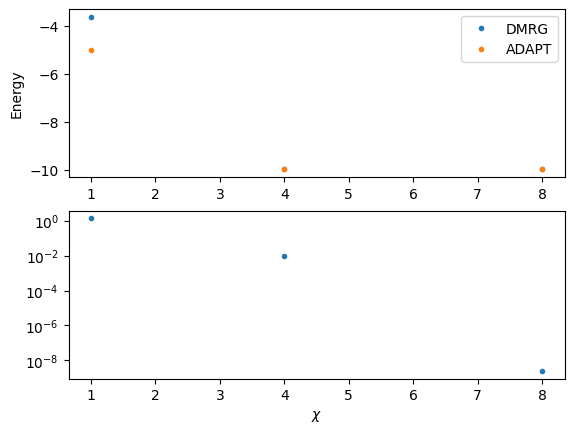

In [12]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(df["chi"], df["dmrg_energy"], '.', label="DMRG")
ax[0].plot(df["chi"], df["adapt_energy"], '.', label="ADAPT")
ax[0].legend()
ax[0].set_ylabel("Energy")
ax[1].plot(df["chi"], df["error"], '.')
ax[1].set_yscale("log")
ax[1].set_xlabel(r"$\chi$")